## Imports


In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import cdist
import numpy as np

## Downloading dataset

In [3]:
file_path = '../dataset/full_dataset.csv'
data = pd.read_csv(file_path)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 95 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   City                                                                             10337 non-null  object 
 1   Country                                                                          10337 non-null  object 
 2   alpha-2                                                                          10332 non-null  object 
 3   alpha-3                                                                          10337 non-null  object 
 4   region                                                                           10337 non-null  object 
 5   sub-region                                                                       10337 non-null  object 
 6   full.l

,City,Country,alpha-2,alpha-3,region,sub-region,full.location.name,latitude,longitude,TMN,...,Polis,Sharing Cities,Sustainable Cities International (SCI),UNIDO Eco-Cities Network in Southeast Asia,Union of the Baltic Cities (UBC),URBACT - Agri-Urban,URBACT - CityMobilNet,URBACT - Resilient Europe,World Association of Major Metropolises (METROPOLIS),World Mayors Council on Climate Change (WCMMM)
0,Asad Abad,Afghanistan,AF,AFG,Asia,Southern Asia,"Asad Abad, Afghanistan",34.874264,71.153764,1,...,0,0,0,0,0,0,0,0,0,0
1,Bamiyan,Afghanistan,AF,AFG,Asia,Southern Asia,"Bamiyan, Afghanistan",34.810007,67.821210,1,...,0,0,0,0,0,0,0,0,0,0
2,Chaharbagh,Afghanistan,AF,AFG,Asia,Southern Asia,"Chaharbagh, Afghanistan",34.532429,70.287338,1,...,0,0,0,0,0,0,0,0,0,0
3,Faryab,Afghanistan,AF,AFG,Asia,Southern Asia,"Faryab, Afghanistan",36.079561,64.905955,1,...,0,0,0,0,0,0,0,0,0,0
4,Feyzabad,Afghanistan,AF,AFG,Asia,Southern Asia,"Feyzabad, Afghanistan",37.101709,70.555236,1,...,0,0,0,0,0,0,0,0,0,0


## Data normalizing

In [11]:
excluded_columns = ['City', 'Country', 'alpha-2', 'alpha-3', 'region', 'full.location.name', 'latitude', 'longitude', 'TMN', 'ETMN']

selected_columns = [col for col in data.columns if col not in excluded_columns]
data_selected = data[selected_columns]
numeric_data = data_selected.select_dtypes(include=['number']).dropna()

scaler = StandardScaler()
normalized_data = scaler.fit_transform(numeric_data)

## Hierarchical clustering and dendrogram construction

(documentation/information_about_hierarchical_anomaly 1)

In [6]:
linkage_matrix_ward = linkage(normalized_data, method='ward')

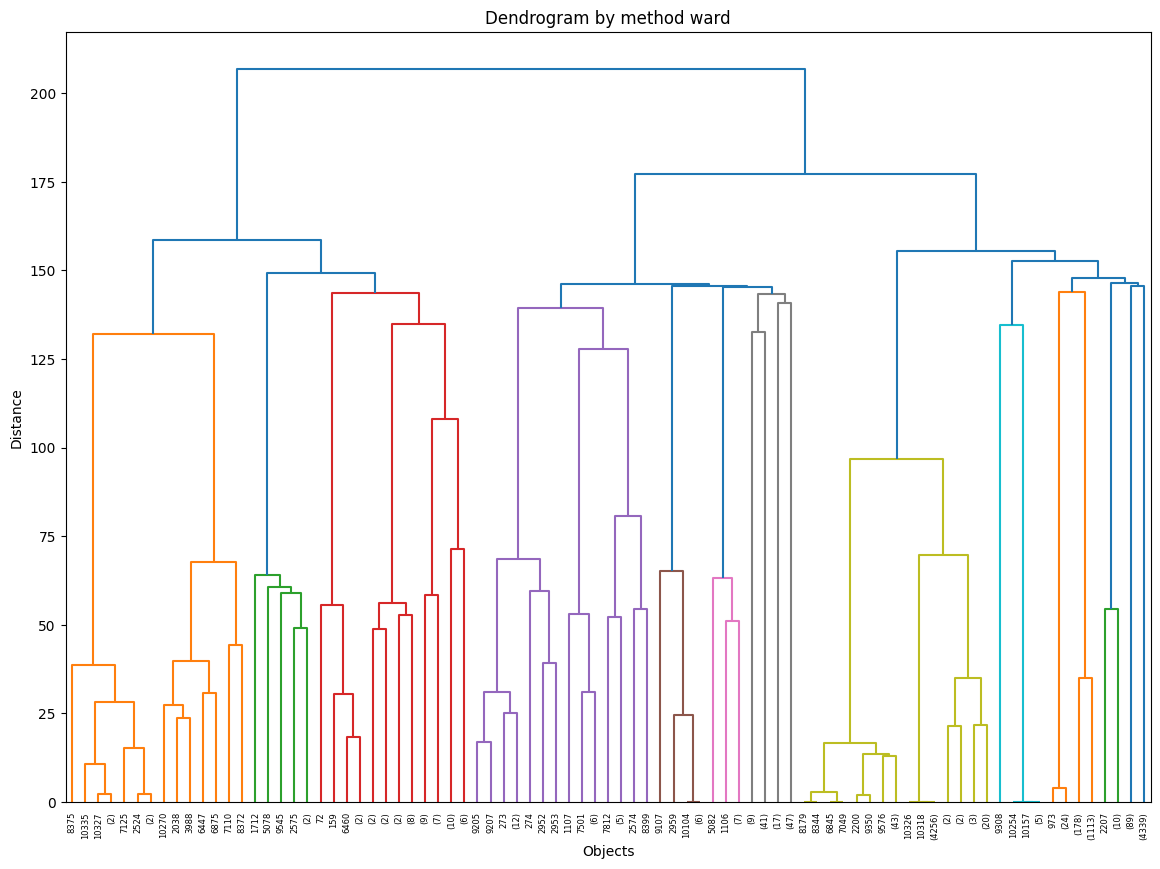

In [46]:
plt.figure(figsize=(14, 10))
dendrogram(linkage_matrix_ward, labels=data_selected.index, leaf_rotation=90, truncate_mode='level', p=6)
plt.title('Dendrogram by method ward')
plt.xlabel('Objects')
plt.ylabel('Distance')
plt.show()

## Analysis of the categorical variable `sub-region`

(documentation/information_about_hierarchical_anomaly 2)

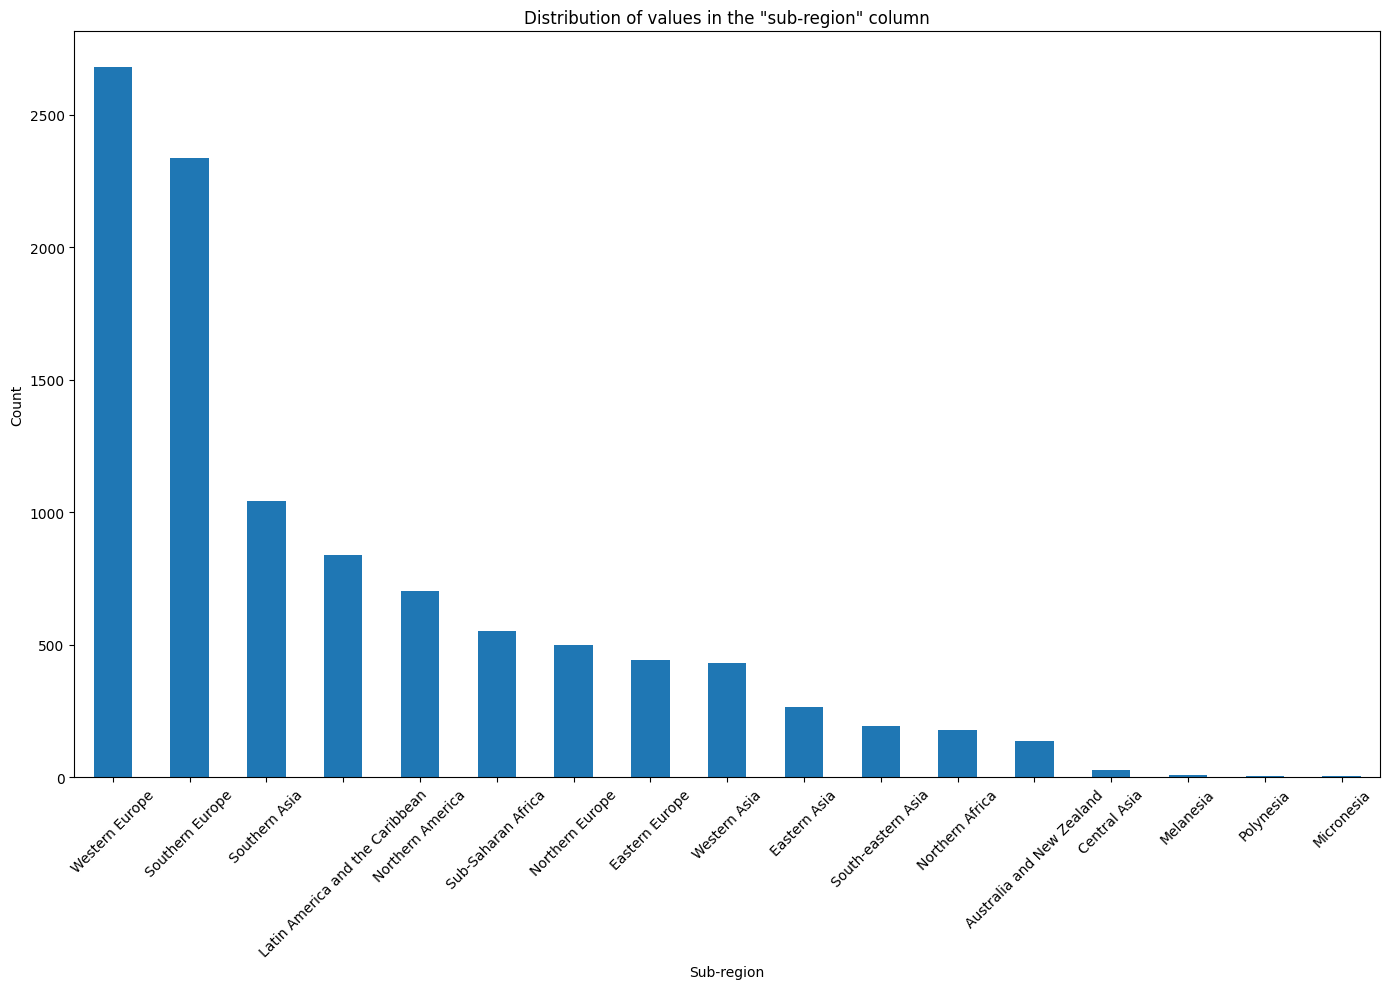

In [45]:
subregion_counts = data_selected['sub-region'].value_counts()

plt.figure(figsize=(14, 10))
subregion_counts.plot(kind='bar')
plt.title('Distribution of values in the "sub-region" column')
plt.xlabel('Sub-region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Distribution of numerical data

(documentation/information_about_hierarchical_anomaly 3)

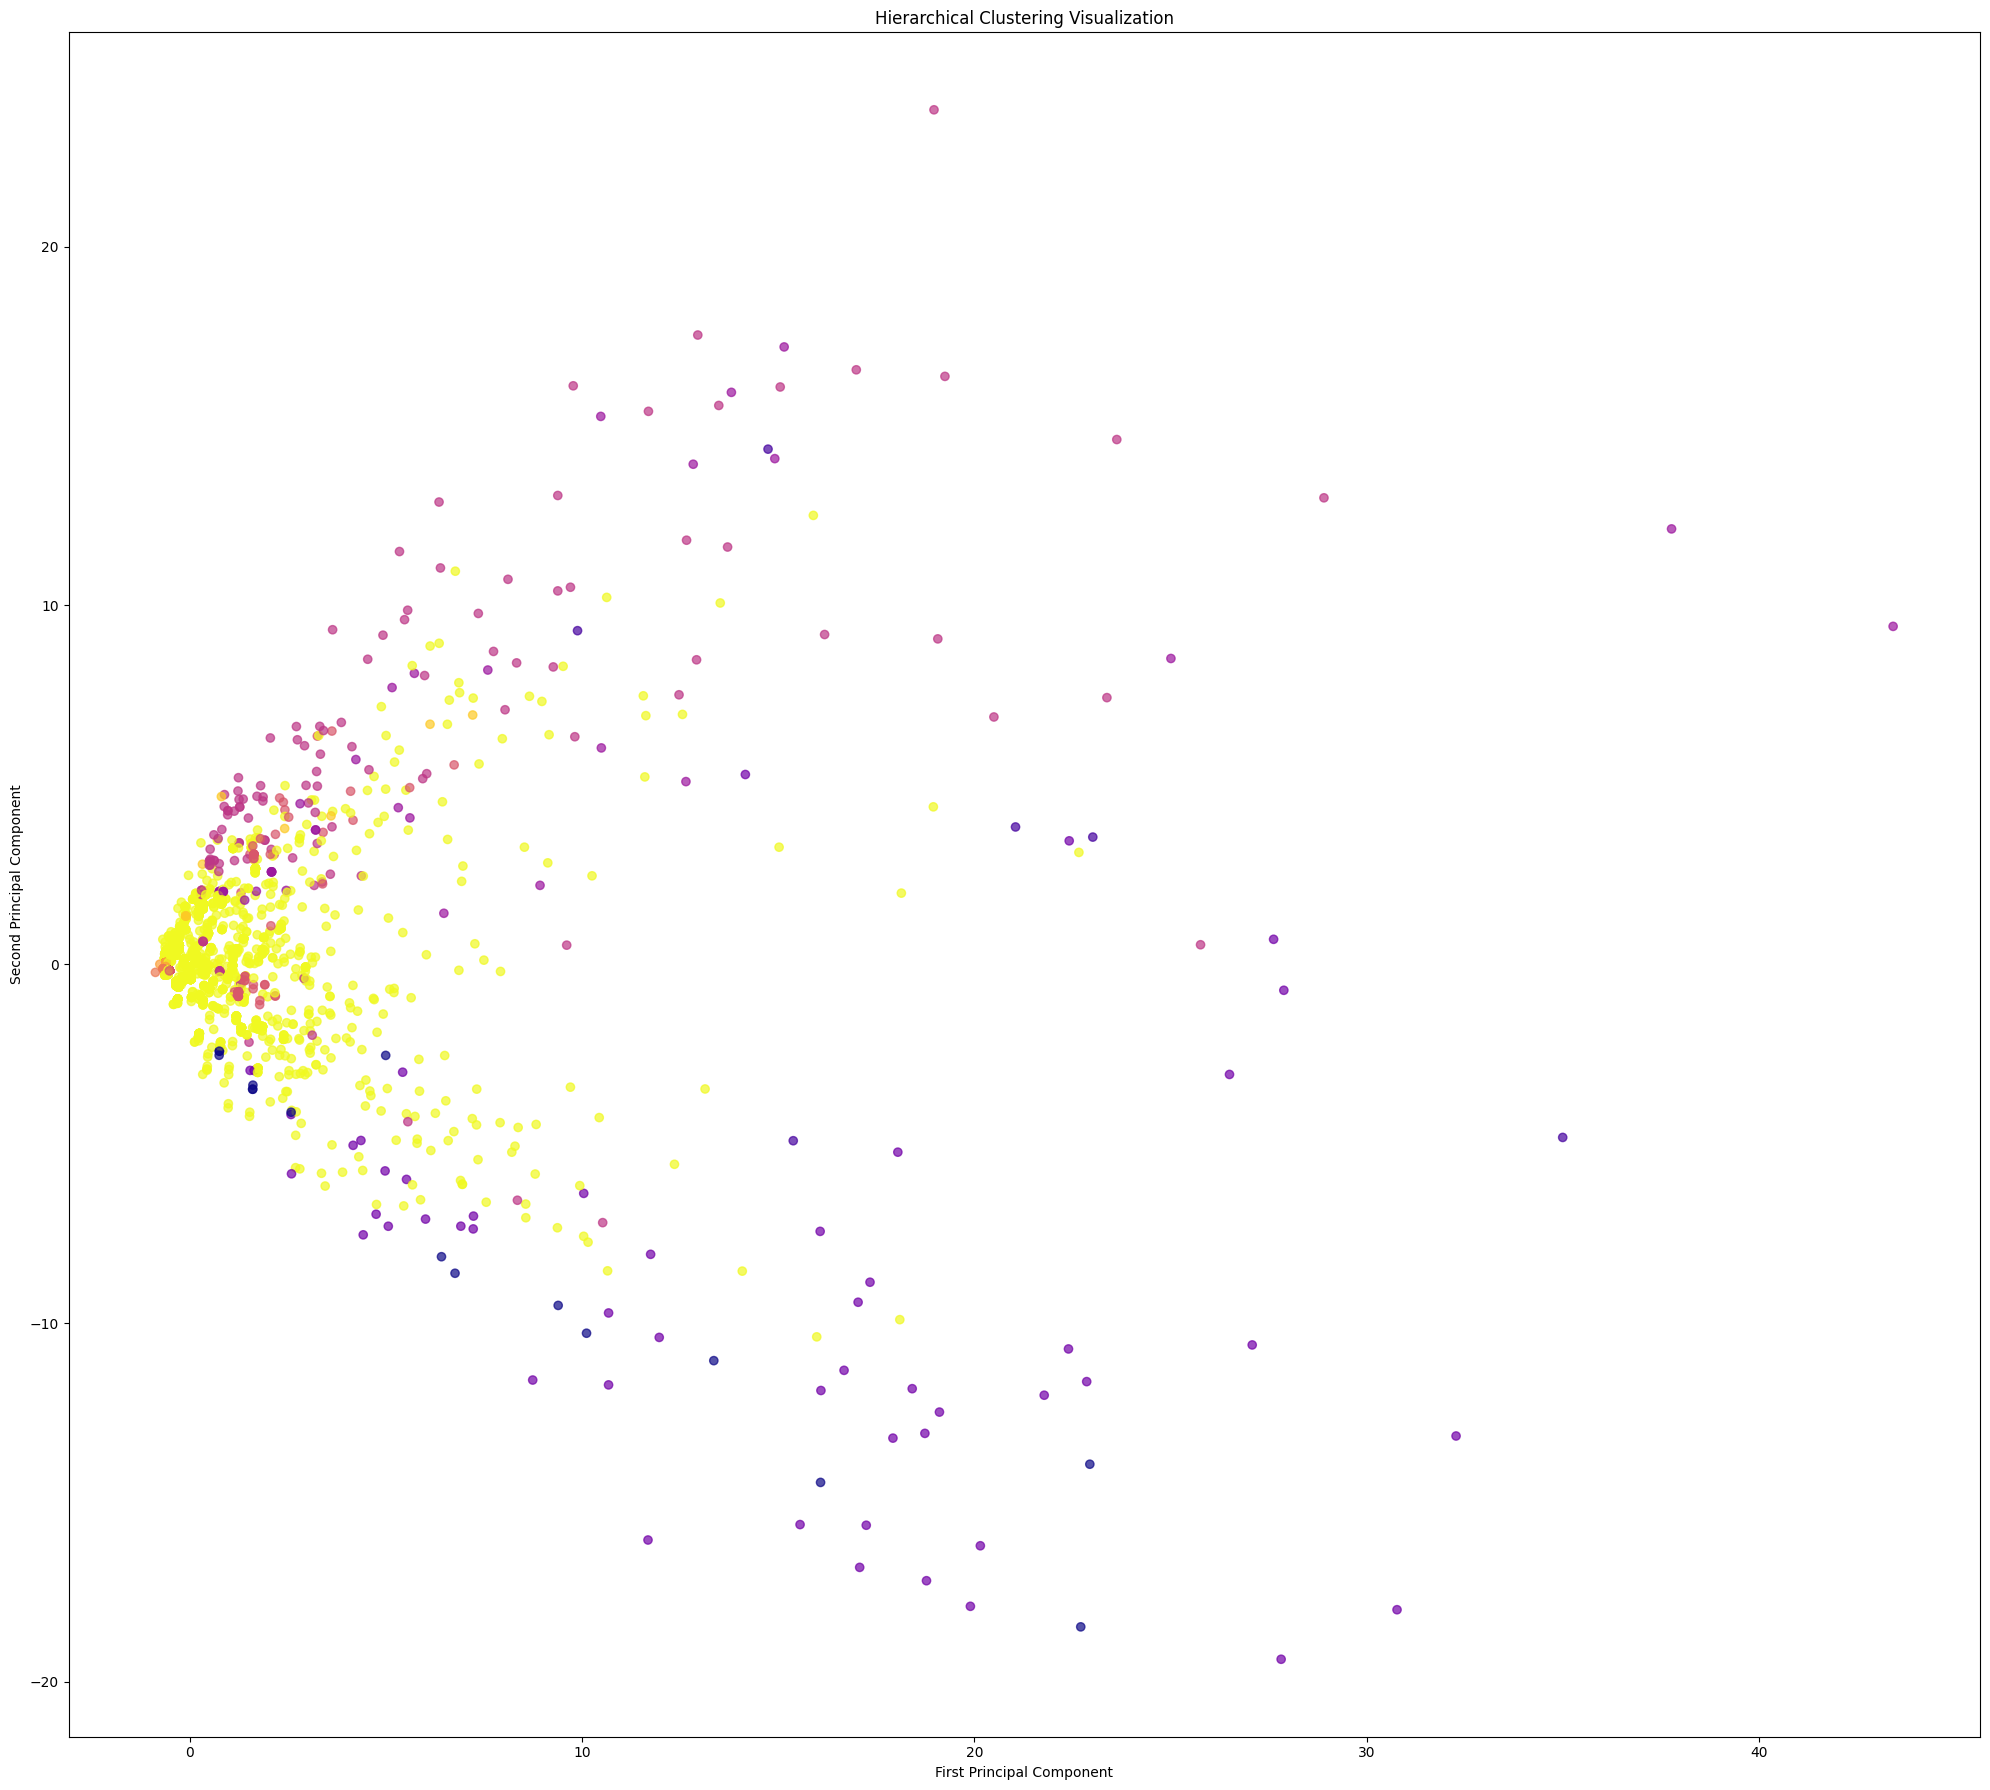

In [43]:
num_clusters = 10
clusters = fcluster(linkage_matrix_ward, num_clusters, criterion='maxclust')
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

plt.figure(figsize=(20, 18))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='plasma', alpha=0.7)
plt.title('Hierarchical Clustering Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.tight_layout()
plt.show()

## Local Outlier Factor (LOF) for anomaly detection

In [33]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # 5% expected anomalies
outlier_labels = lof.fit_predict(reduced_data)  # -1 indicates anomalies
anomaly_indices_lof = np.where(outlier_labels == -1)[0]

## Visualize anomalies in PCA space

(documentation/information_about_hierarchical_anomaly anomaly 1)

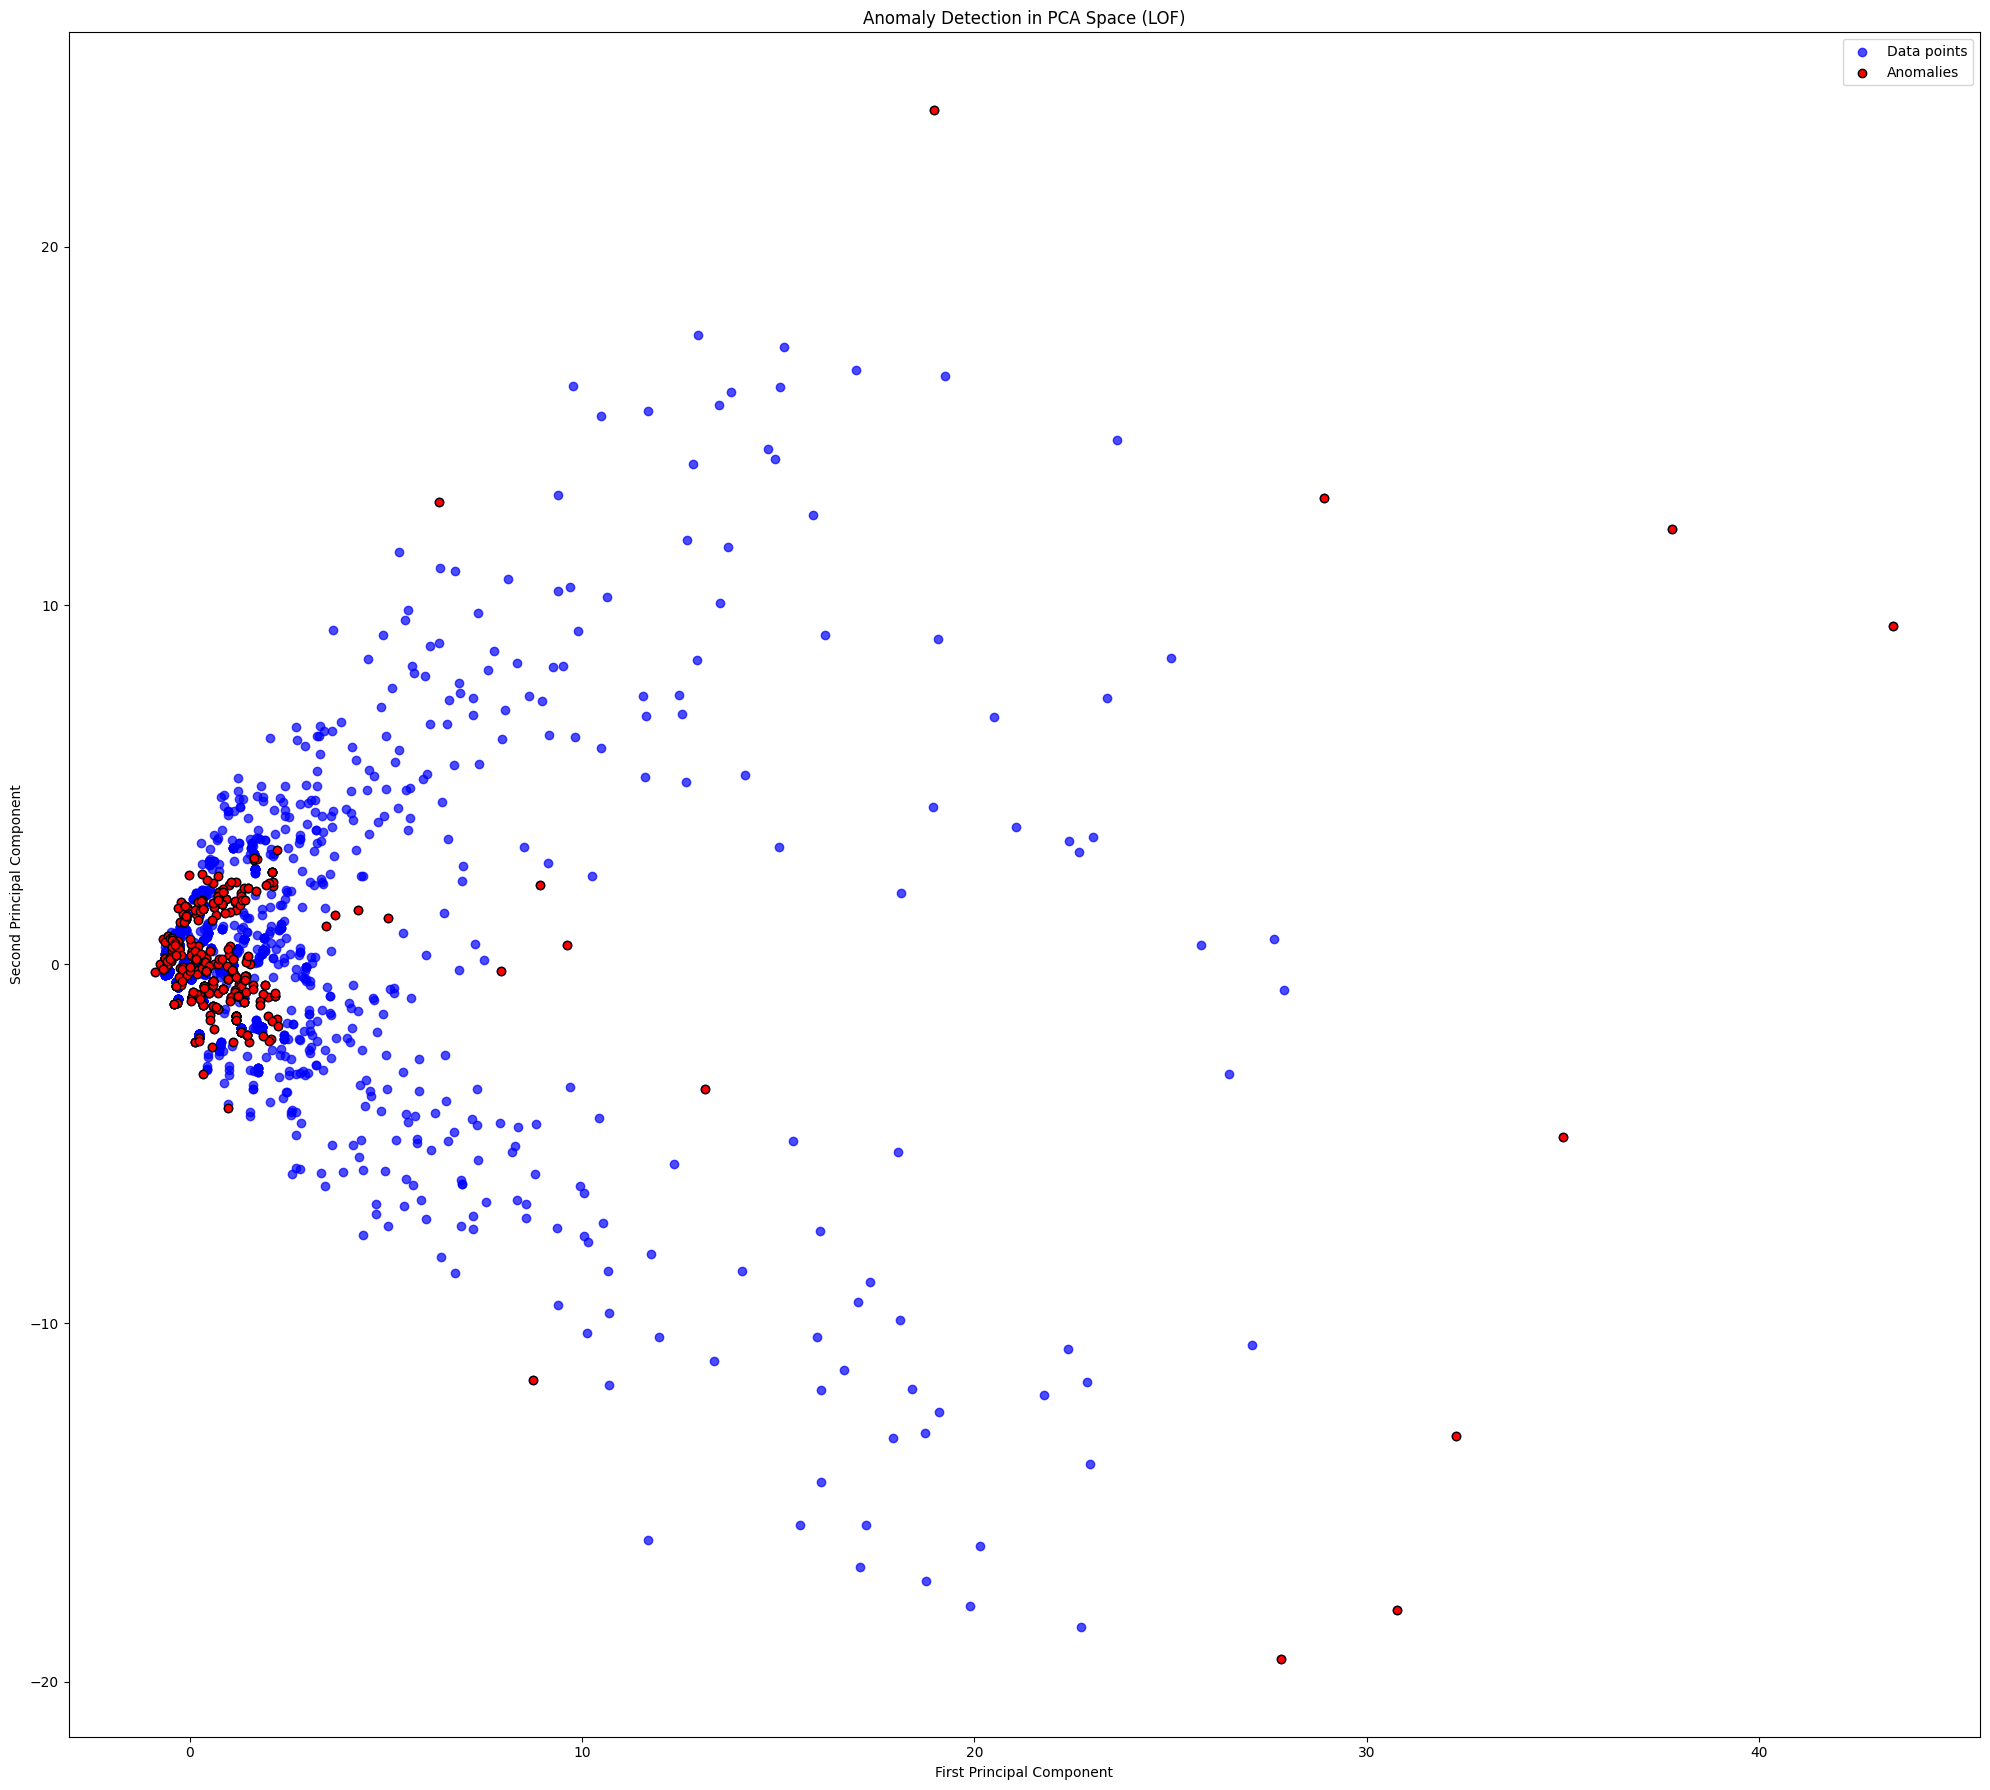

In [41]:
plt.figure(figsize=(20, 18))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.7, label='Data points')
plt.scatter(reduced_data[anomaly_indices_lof, 0], reduced_data[anomaly_indices_lof, 1], 
            c='red', label='Anomalies', edgecolor='k')
plt.title('Anomaly Detection in PCA Space (LOF)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.tight_layout()
plt.show()

## Distance-based anomaly detection

In [35]:
centroids = np.array([reduced_data[clusters == k].mean(axis=0) for k in range(1, num_clusters + 1)])
distances = cdist(reduced_data, centroids, metric='euclidean')
min_distances = distances.min(axis=1)

## Define threshold for anomalies

(documentation/information_about_hierarchical_anomaly anomaly 3)

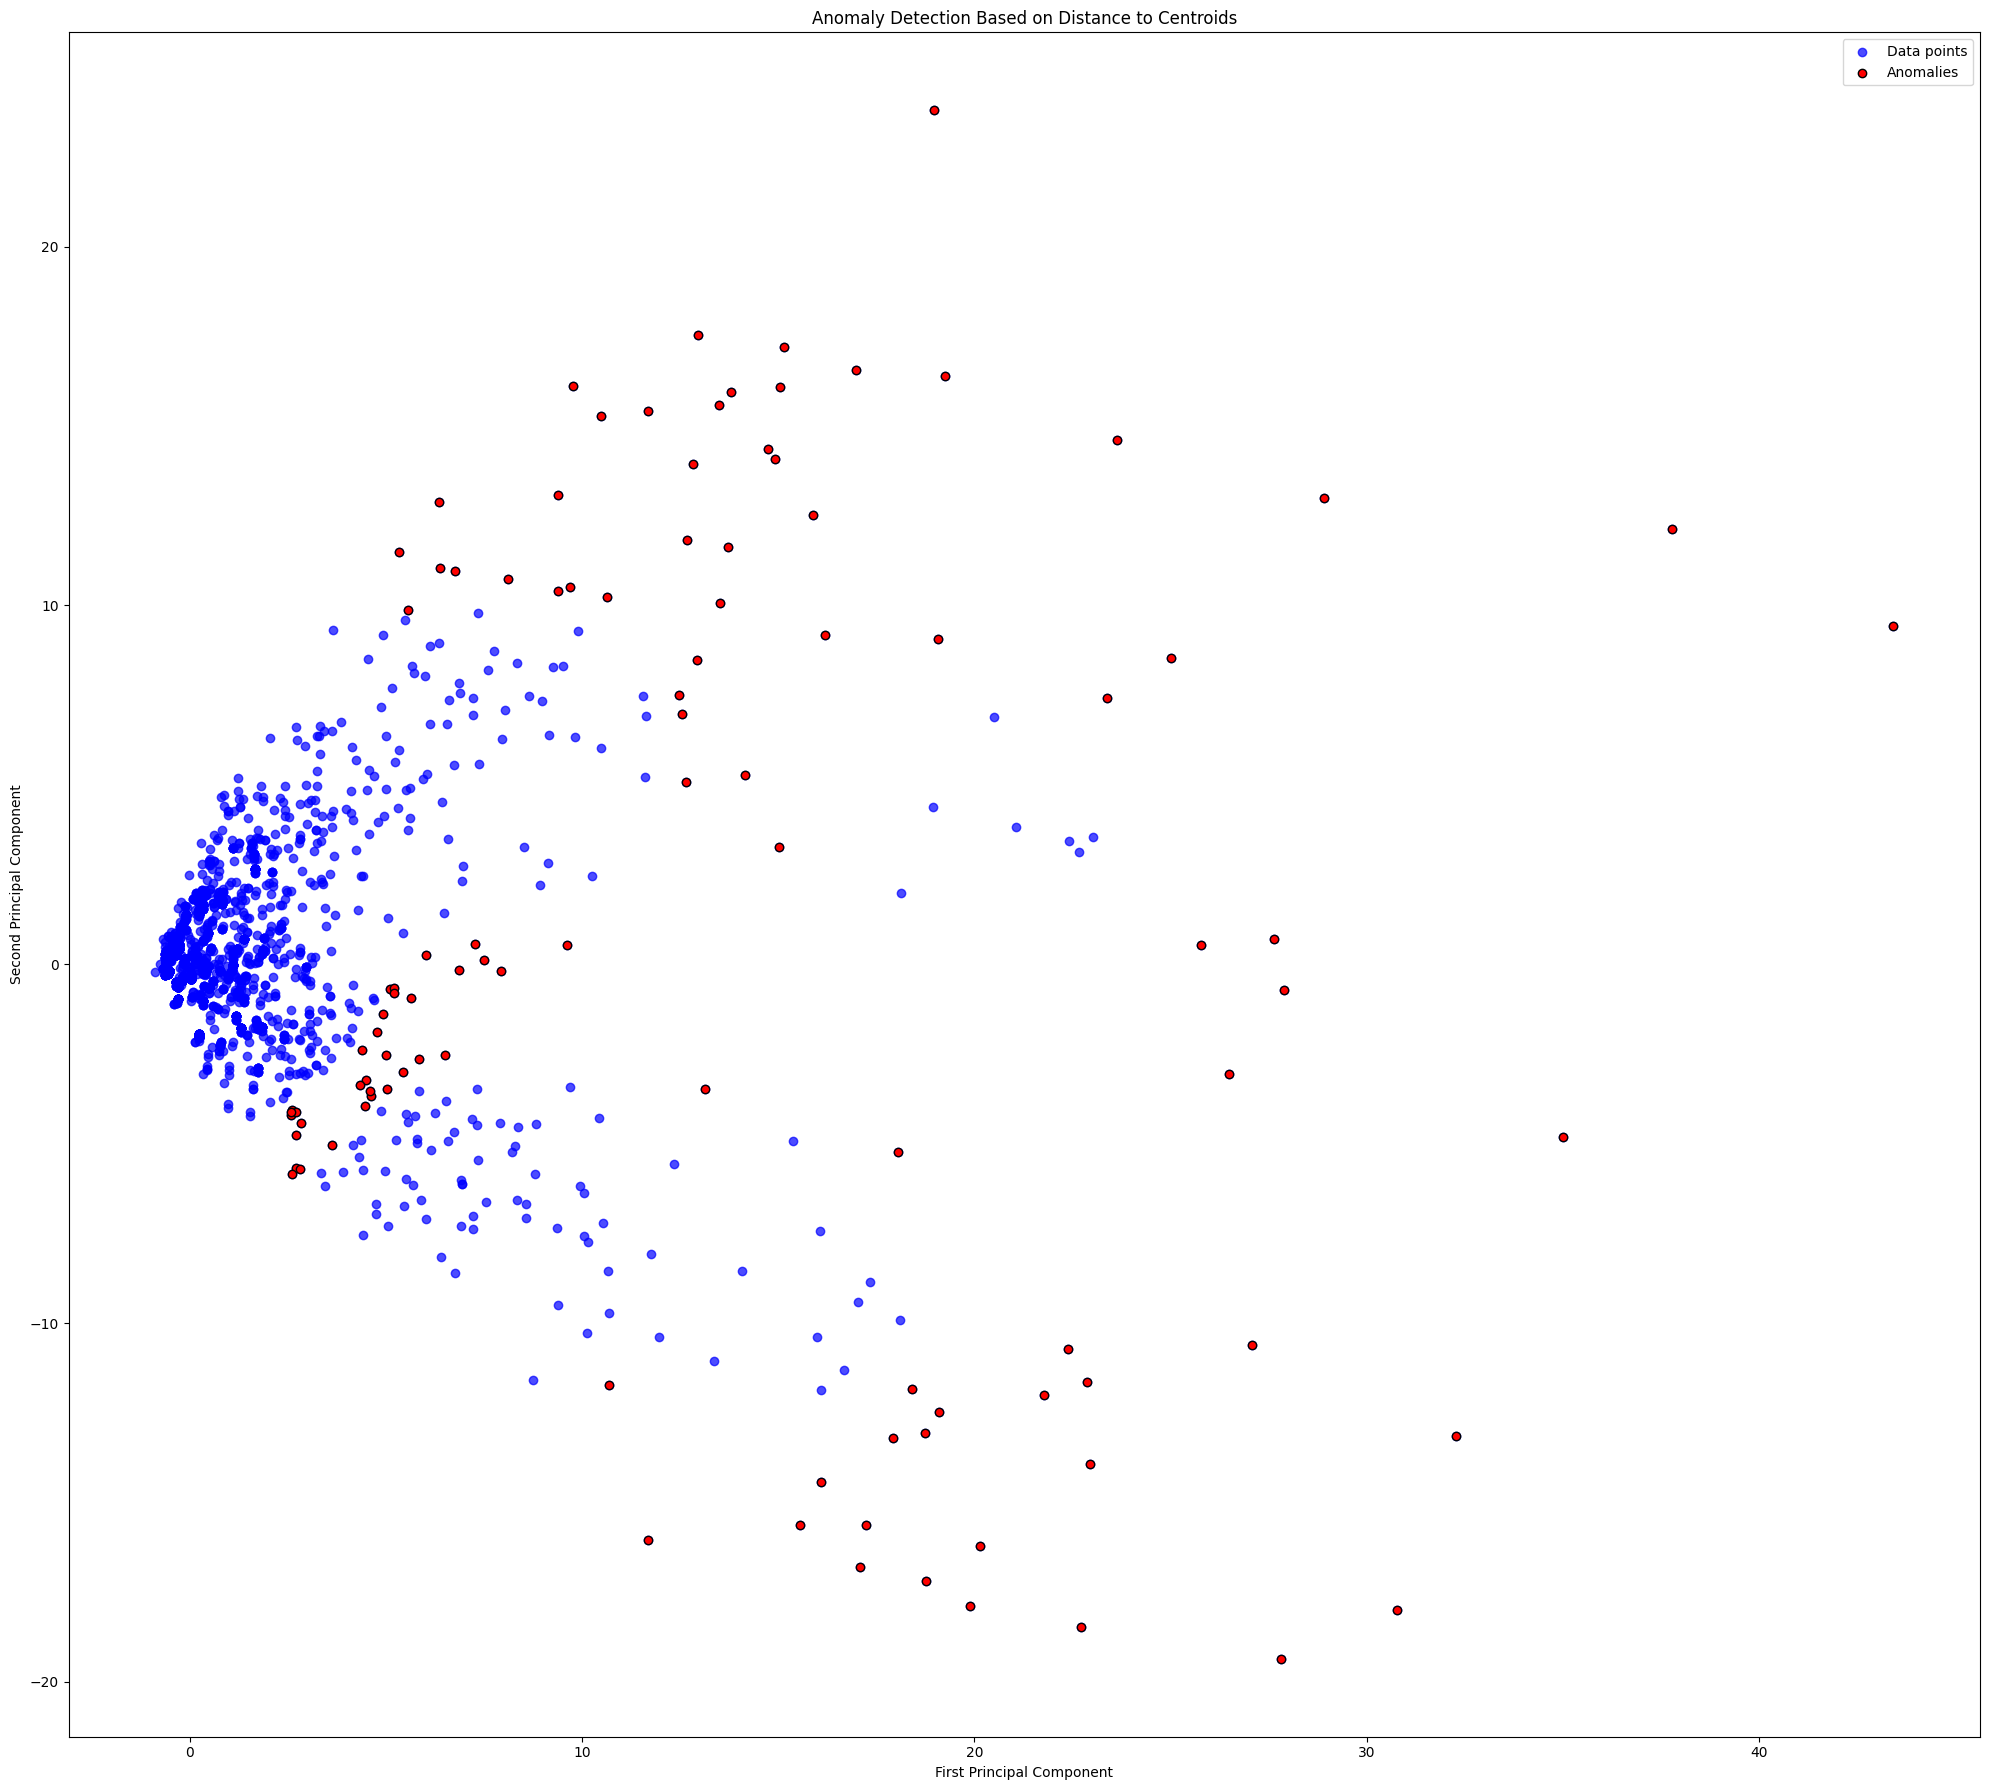

In [42]:
distance_threshold = np.percentile(min_distances,99)
anomaly_indices_distance = np.where(min_distances > distance_threshold)[0]

plt.figure(figsize=(20, 18))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.7, label='Data points')
plt.scatter(reduced_data[anomaly_indices_distance, 0], reduced_data[anomaly_indices_distance, 1], 
            c='red', label='Anomalies', edgecolor='k')
plt.title('Anomaly Detection Based on Distance to Centroids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.tight_layout()
plt.show()